<a href="https://colab.research.google.com/github/boangri/uai-thesis-notebooks/blob/main/notebooks/DQN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Q Learning

## Imports

In [ ]:
!pip install box2d-py # для Lunarlander

     |████████████████████████████████| 450kB 5.8MB/s 


In [ ]:
!pip install pyvirtualdisplay 
!pip install xvfbwrapper 
!apt-get update 
!apt-get install xvfb

  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-cp37-none-any.whl size=5009 sha256=f9dd2bce163856c8d9c4ff1bfdd76dc49e93c2f701e9c142ded59d0cea84fd87
  Stored in directory: /root/.cache/pip/wheels/10/f2/61/cacfaf84b352c223761ea8d19616e3b5ac5c27364da72863f0
Successfully built xvfbwrapper
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [49.8 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:8 http://security.ubuntu.com/ubuntu bionic-security I

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
import glob 
import io 
import base64 
from IPython.display import HTML 
import time 
from IPython import display as ipythondisplay 
from pyvirtualdisplay import Display 
import gym
from gym import wrappers
from gym import logger as gymlogger 
from gym.wrappers import Monitor 
gymlogger.set_level(40)
import json

In [ ]:
algo='DQN'
home_dir = os.path.join('/content/drive/MyDrive/Thesys', algo)

## Classes & Functions

### ReplayBuffer

In [ ]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape):
        self.mem_size = max_size
        self.mem_cntr = 0
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done
        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        states_ = self.new_state_memory[batch]
        terminal = self.terminal_memory[batch]

        return states, actions, rewards, states_, terminal

### DeepQNetwork

In [ ]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super().__init__()
        
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    

### EpsilonGreedy

In [ ]:
class EpsilonGreedy():
    def __init__(self, epsilon=1.0, eps_min=0.01, eps_dec=1e-5):
        self.epsilon = epsilon
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        return

    def isGreedy(self):
        return True if np.random.random() > self.epsilon else False

    def decrement(self):
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min
        return self.epsilon


### DQNAgent

In [ ]:
class DQNAgent(object):
    def __init__(self, epsilonGreedy, replayBuffer, evalNetwork, nextNetwork, input_dims, n_actions, batch_size, gamma, replace, chkpt_dir, name):
        self.gamma = gamma
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.batch_size = batch_size
        self.replace_target_cnt = replace
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0

        self.epsilon_greedy = epsilonGreedy
        self.memory = replayBuffer
        self.q_eval = evalNetwork
        self.q_next = nextNetwork
        self.q_next.load_state_dict(self.q_eval.state_dict())

    def choose_action(self, observation):
        if self.epsilon_greedy.isGreedy():
            state = T.tensor([observation], dtype=T.float).to(self.q_eval.device)
            actions = self.q_eval.forward(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_memory(self):
        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        states_ = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, states_, dones

    def replace_target_network(self):
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.q_next.load_state_dict(self.q_eval.state_dict())

    def save_models(self):
        print('... saving checkpoint ...', end='')
        T.save(self.q_eval.state_dict(), self.checkpoint_file)
        print(' saved.')

    def load_models(self):
        print('... loading checkpoint ...', end='')
        self.q_eval.load_state_dict(T.load(self.checkpoint_file))
        self.q_next.load_state_dict(self.q_eval.state_dict())
        print(' loaded.')

    def learn(self):
        if self.memory.mem_cntr < self.batch_size:
            return

        self.q_eval.optimizer.zero_grad()

        self.replace_target_network()

        states, actions, rewards, states_, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        q_pred = self.q_eval.forward(states)[indices, actions]
        q_next = self.q_next.forward(states_).max(dim=1)[0]

        q_next[dones] = 0.0
        q_target = rewards + self.gamma*q_next

        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)
        loss.backward()
        self.q_eval.optimizer.step()
        self.learn_step_counter += 1

        self.epsilon_greedy.decrement()

        return loss.to('cpu').detach().numpy()

### Evaluator

In [ ]:
class Evaluator:
    def __init__(self, evalNetwork):
        self.q_eval = evalNetwork

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.q_eval.device)
        actions = self.q_eval.forward(state)
        action = T.argmax(actions).item()

        return action

### learn()

In [ ]:
def learn(env, agent, n_games, history_file, freq=10):
    for i in range(n_games):
        score = 0
        done = False
        obs = env.reset()
        steps = 0
        while not done:
            action = agent.choose_action(obs)
            obs_, reward, done, info = env.step(action)
            score += reward
            steps += 1
            agent.store_transition(obs, action, reward, obs_, int(done))
            agent.learn()
            obs = obs_
        scores.append(score)
        eps_history.append(agent.epsilon_greedy.epsilon)

        if (i + 1) % freq == 0:
            avg_score = np.mean(scores[-100:])
            print('episode ', i + 1, 'score %.1f avg score %.1f epsilon %.2f steps %d' %
                    (score, avg_score, agent.epsilon_greedy.epsilon, steps))
        with open(history_file, 'a') as h:   
            h.write("%d,%.2f,%.2f,%d\n" % (i + 1, score, agent.epsilon_greedy.epsilon, steps)) 
    agent.save_models()

### test()

In [ ]:
def test(env, agent, episodes=100, csv_file=None):
    total = 0.
    for ep in range(episodes):
        score = 0.
        obs = env.reset()
        done = False
        while not done:
            action = agent.choose_action(obs)
            obs, reward, done, _ = env.step(action)
            score += reward
        if (ep + 1) % 10 == 0:
            print("episode: %d Score: %1.f" % (ep+1, score))
        total += score
        if csv_file:
            with open(csv_file, 'a') as h:   
                h.write("%d,%.3f\n" % (ep + 1, score))
    print("Average score %.2f" % (total/episodes))


### video()

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()

def video(env, agent, dir, seed=42):
    env.seed(seed)
    env = wrap_env(env)
    obs = env.reset()
    done = False
    score = 0.
    while not done:
        env.render()
        action = agent.choose_action(obs)
        obs, reward, done, _ = env.step(action)
        score += reward
    env.close()
    print("Score=%.2f" % score)
    show_video(dir)

def show_video(dir):    
    mp4list = glob.glob(os.path.join(dir, 'video/*.mp4'))
    if len(mp4list) > 0:
        mp4 = mp4list[0]
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else: 
        print("Could not find video")
    
def wrap_env(env):
    env = Monitor(env, os.path.join(dir, 'video'), force=True)
    return env

### plot_history()

In [ ]:
def plot_history(path, ylim=None):
    df = pd.read_csv(path + '.csv', header=None, names=('episode', 'score', 'epsilon', 'steps'))
    x = df.episode
    y = df.score
    y1 = np.zeros_like(y)
    for i in range(len(x)):
        y1[i] = np.mean(y[i-100:i])
    eps = df.epsilon
    fig = plt.figure(figsize=(12,12))
    plt.subplot(2, 1, 1)
    plt.plot(x, y, 'o', markersize=3, color='C0', label='очки')
    plt.plot(x, y1, color='C1', label='среднее за 100')
    plt.ylabel('Очки')
    plt.xlabel('Эпизоды')
    plt.legend()
    plt.grid()
    if ylim:
        plt.ylim(*ylim)
    plt.title(f'История обучения - {env_name} {algo}')
    plt.subplot(2, 1, 2)
    plt.plot(x, eps, color='C2', label='epsilon')
    plt.ylabel('Epsilon')
    plt.xlabel('Эпизоды')
    plt.legend()
    plt.grid()
    plt.title(f'История обучения - {env_name} {algo}')
    plt.show()
    fig.savefig(os.path.join(path + '.png'))

In [ ]:
def plot_test(csv_file):
    df = pd.read_csv(csv_file, header=None, names=('episode', 'score'))
    x = df.episode
    y = df.score
    y1 = np.zeros_like(y)
    for i in range(len(x)):
        y1[i] = np.mean(y[i-100:i])
    fig = plt.figure(figsize=(12,12))
    plt.plot(x, y, 'o', markersize=3, color='C0', label='очки')
    plt.plot(x, y1, color='C1', label='среднее за 100')
    plt.ylabel('Очки')
    plt.xlabel('Эпизоды')
    plt.legend()
    plt.grid()
    plt.title(f'Тестирование - {env_name} {algo}')
    plt.show()
    fig.savefig(os.path.join(dir, 'test.png'))

## LunarLander-v2

### Гиперпараметры

In [ ]:
hp = dict(
    env_name='LunarLander-v2',
    algo=algo,
    id='04',
    horizon=100,
    avg_reward=1.,
    n_episodes=3000,
    n_steps=200,
    lr=0.0001,
    buf_size=100000,
    batch_size=128,
    layers=[256, 256],
    eps_min=0.01,
    eps_factor=4,
)
env_name = hp['env_name']
dir = os.path.join(home_dir, env_name)
dir = os.path.join(dir, hp['id'])
path = os.path.join(dir, 'history')
!mkdir -p $dir 
with open(dir + "/hp.json", "w") as json_file:
    json.dump(hp, json_file)

In [ ]:
env = gym.make(env_name)
Nh = hp['horizon']
sf = hp['avg_reward'] * Nh 
gamma = 1 - 1/Nh
n_episodes = hp['n_episodes']
n_steps = hp['n_steps']
scores = []
eps_history = []
lr = hp['lr']
input_dims = env.observation_space.shape
n_actions = env.action_space.n
batch_size = hp['batch_size']

fc1_dims, fc2_dims = hp['layers']

epsilonGreedy = EpsilonGreedy(eps_dec=hp['eps_factor']/n_steps/n_episodes, eps_min=hp['eps_min'])

replayBuffer = ReplayBuffer(max_size=hp['buf_size'], input_shape=input_dims)

evalNetwork = DeepQNetwork(lr=lr, n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims, input_dims=input_dims)

nextNetwork = DeepQNetwork(lr=lr, n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims, input_dims=input_dims)

agent = DQNAgent(epsilonGreedy, replayBuffer, evalNetwork, nextNetwork, input_dims, n_actions, gamma=gamma, batch_size=batch_size, replace=1000, name=env_name + '_' + algo, chkpt_dir=dir)

### Обучение

In [ ]:
%%time
history_file = path + '.csv'
!rm -rf $history_file

freq = 10
for ep in range(n_episodes):
    score = 0.
    avg_loss = 0.
    learn_count = 0
    done = False
    obs = env.reset()
    steps = 0
    while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, info = env.step(action)
        score += reward
        steps += 1
        agent.store_transition(obs, action, reward, obs_, int(done))
        loss = agent.learn()
        if loss is not None:
            avg_loss += pow(loss, 0.5)*sf
            learn_count += 1
        obs = obs_
    scores.append(score)
    eps_history.append(agent.epsilon_greedy.epsilon)
    if learn_count > 0:
        avg_loss /= learn_count
    if (ep + 1) % freq == 0:
        avg_score = np.mean(scores[-10*freq:])
        print('episode ', ep + 1, 'score %.3f avg score %.3f epsilon %.3f avg_loss %.3f steps %d' %
                (score, avg_score, agent.epsilon_greedy.epsilon, avg_loss, steps))
    with open(history_file, 'a') as h:   
        h.write("%d,%.3f,%.3f\n" % (ep + 1, score, agent.epsilon_greedy.epsilon)) 
agent.save_models()

episode  10 score -7.746 avg score -124.202 epsilon 0.994 avg_loss 813.328 steps 139
episode  20 score -103.851 avg score -143.228 epsilon 0.987 avg_loss 817.871 steps 98
episode  30 score -55.132 avg score -151.358 epsilon 0.981 avg_loss 787.893 steps 64
episode  40 score -47.054 avg score -162.046 epsilon 0.974 avg_loss 750.242 steps 65
episode  50 score -110.737 avg score -158.109 epsilon 0.968 avg_loss 642.104 steps 62
episode  60 score -97.881 avg score -162.255 epsilon 0.961 avg_loss 599.996 steps 102
episode  70 score -182.398 avg score -156.582 epsilon 0.955 avg_loss 619.305 steps 121
episode  80 score -184.584 avg score -162.619 epsilon 0.948 avg_loss 565.993 steps 130
episode  90 score -371.679 avg score -168.937 epsilon 0.942 avg_loss 574.012 steps 123
episode  100 score -268.411 avg score -168.628 epsilon 0.934 avg_loss 512.042 steps 136
episode  110 score -294.926 avg score -174.395 epsilon 0.927 avg_loss 554.353 steps 113
episode  120 score -69.551 avg score -174.532 epsi

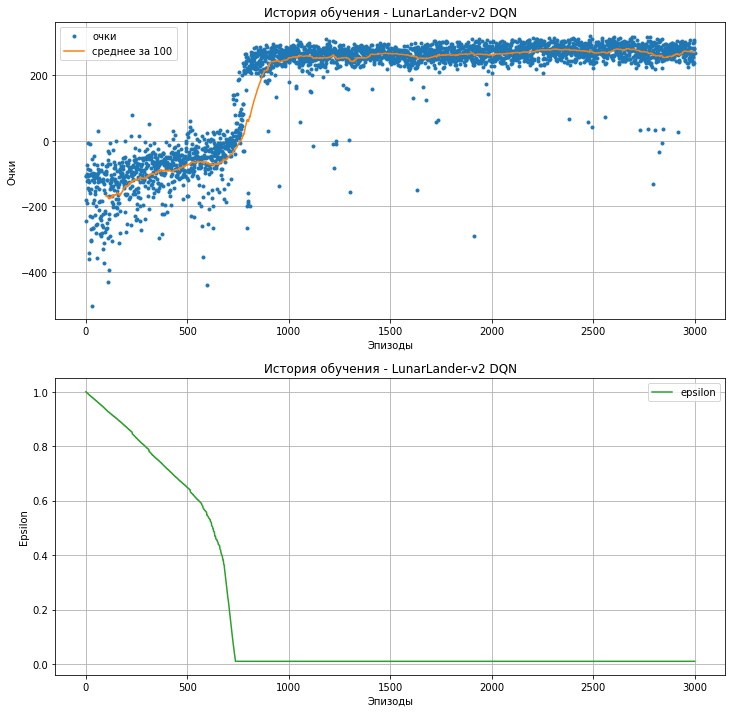

{'algo': 'DQN',
 'avg_reward': 1.0,
 'batch_size': 128,
 'buf_size': 100000,
 'env_name': 'LunarLander-v2',
 'eps_factor': 4,
 'eps_min': 0.01,
 'horizon': 100,
 'id': '04',
 'layers': [256, 256],
 'lr': 0.0001,
 'n_episodes': 3000,
 'n_steps': 200}

In [ ]:
plot_history(path)
hp

### Тестирование

In [ ]:
%%time
env = gym.make(env_name)
agent.epsilon_greedy.epsilon = 0.
agent.epsilon_greedy.eps_min = 0.
test(env, agent)

episode: 10 Score: 278
episode: 20 Score: 295
episode: 30 Score: 277
episode: 40 Score: 259
episode: 50 Score: 299
episode: 60 Score: 299
episode: 70 Score: 237
episode: 80 Score: 310
episode: 90 Score: 275
episode: 100 Score: 290
Average score 271.04
CPU times: user 17.2 s, sys: 162 ms, total: 17.3 s
Wall time: 17.3 s


### Video

In [ ]:
env = gym.make(env_name)
video(env, agent, dir, seed=42)

Score=285.71


## CartPole-v1

### Гиперпараметры

In [ ]:
hp = dict(
    env_name='CartPole-v1',
    algo=algo,
    id='03',
    horizon=100,
    avg_reward=1.,
    n_episodes=3000,
    n_steps=500,
    lr=0.0001,
    buf_size=100000,
    batch_size=128,
    layers=[64, 64],
    eps_min=0.01,
    eps_factor=30,
)
env_name = hp['env_name']
dir = os.path.join(home_dir, env_name)
dir = os.path.join(dir, hp['id'])
path = os.path.join(dir, 'history')
!mkdir -p $dir 
with open(dir + "/hp.json", "w") as json_file:
    json.dump(hp, json_file)

In [ ]:
env = gym.make(env_name)
Nh = hp['horizon']
sf = hp['avg_reward'] * Nh 
gamma = 1 - 1/Nh
n_episodes = hp['n_episodes']
n_steps = hp['n_steps']
scores = []
eps_history = []
lr = hp['lr']
input_dims = env.observation_space.shape
n_actions = env.action_space.n
batch_size = hp['batch_size']

fc1_dims, fc2_dims = hp['layers']

epsilonGreedy = EpsilonGreedy(eps_dec=hp['eps_factor']/n_steps/n_episodes, eps_min=hp['eps_min'])

replayBuffer = ReplayBuffer(max_size=hp['buf_size'], input_shape=input_dims)

evalNetwork = DeepQNetwork(lr=lr, n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims, input_dims=input_dims)

nextNetwork = DeepQNetwork(lr=lr, n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims, input_dims=input_dims)

agent = DQNAgent(epsilonGreedy, replayBuffer, evalNetwork, nextNetwork, input_dims, n_actions, gamma=gamma, batch_size=batch_size, replace=1000, name=env_name + '_' + algo, chkpt_dir=dir)

### Обучение

In [ ]:
%%time
history_file = path + '.csv'
!rm -rf $history_file

freq = 100
for ep in range(n_episodes):
    score = 0.
    avg_loss = 0.
    learn_count = 0
    done = False
    obs = env.reset()
    while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, info = env.step(action)
        score += reward
        agent.store_transition(obs, action, reward, obs_, int(done))
        loss = agent.learn()
        if loss is not None:
            avg_loss += pow(loss, 0.5)*sf
            learn_count += 1
        obs = obs_
    scores.append(score)
    eps_history.append(agent.epsilon_greedy.epsilon)
    if learn_count > 0:
        avg_loss /= learn_count
    if (ep + 1) % freq == 0:
        avg_score = np.mean(scores[-10*freq:])
        print('episode ', ep + 1, 'score %.3f avg score %.3f epsilon %.3f avg_loss %.3f' %
                (score, avg_score, agent.epsilon_greedy.epsilon, avg_loss))
    with open(history_file, 'a') as h:   
        h.write("%d,%.3f,%.3f\n" % (ep + 1, score, agent.epsilon_greedy.epsilon)) 
agent.save_models()

episode  100 score 13.000 avg score 21.990 epsilon 0.959 avg_loss 39.100
episode  200 score 30.000 avg score 22.900 epsilon 0.911 avg_loss 50.737
episode  300 score 19.000 avg score 23.910 epsilon 0.859 avg_loss 68.637
episode  400 score 16.000 avg score 25.898 epsilon 0.795 avg_loss 70.312
episode  500 score 60.000 avg score 27.858 epsilon 0.724 avg_loss 84.582
episode  600 score 61.000 avg score 33.105 epsilon 0.605 avg_loss 123.907
episode  700 score 264.000 avg score 40.827 epsilon 0.431 avg_loss 157.396
episode  800 score 198.000 avg score 63.001 epsilon 0.010 avg_loss 195.986
episode  900 score 170.000 avg score 82.289 epsilon 0.010 avg_loss 188.814
episode  1000 score 166.000 avg score 93.602 epsilon 0.010 avg_loss 175.301
episode  1100 score 178.000 avg score 111.132 epsilon 0.010 avg_loss 108.002
episode  1200 score 325.000 avg score 130.713 epsilon 0.010 avg_loss 31.951
episode  1300 score 215.000 avg score 153.733 epsilon 0.010 avg_loss 26.130
episode  1400 score 190.000 avg

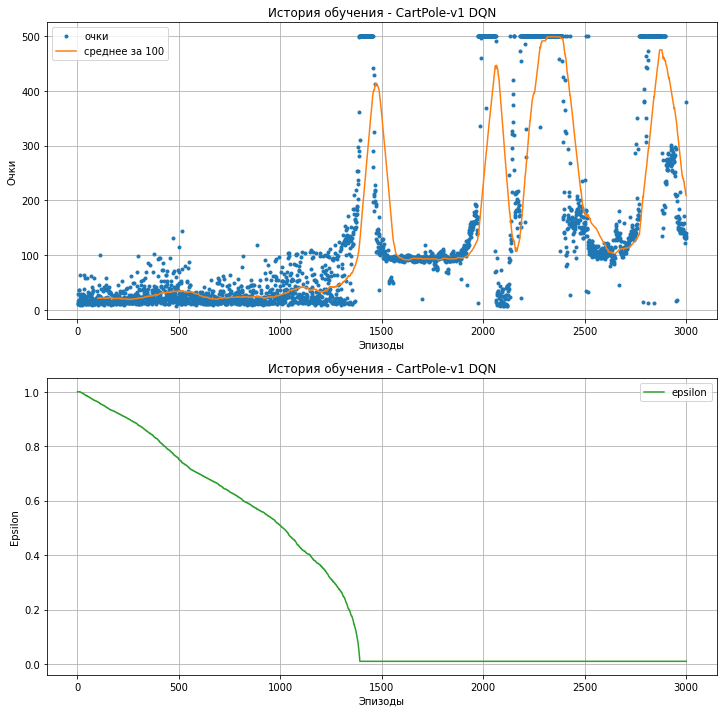

{'algo': 'DQN',
 'avg_reward': 1.0,
 'batch_size': 256,
 'buf_size': 100000,
 'env_name': 'CartPole-v1',
 'eps_factor': 30,
 'eps_min': 0.01,
 'horizon': 500,
 'id': '02',
 'layers': [1024, 512],
 'lr': 0.0001,
 'n_episodes': 3000,
 'n_steps': 500}

In [ ]:
plot_history(path)
hp

In [ ]:
agent = DQNAgent(epsilonGreedy, replayBuffer, evalNetwork, nextNetwork, n_actions, gamma=0.99, batch_size=32, replace=1000, name=env_name + '_' + algo, chkpt_dir=dir)
agent.load_models()

... loading checkpoint ... loaded.


### Тестирование

In [ ]:
checkpoint_file = os.path.join(dir, env_name + '_' + algo)
evalNetwork = DeepQNetwork(lr=lr, n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims, input_dims=input_dims)
evalNetwork.load_state_dict(T.load(checkpoint_file))
eval = Evaluator(evalNetwork)

In [ ]:
%%time
env = gym.make(env_name)

episodes = 100
total = 0.
for ep in range(episodes):
    score = 0.
    obs = env.reset()
    done = False
    while not done:
        action = eval.choose_action(obs)
        obs, reward, done, info = env.step(action)
        score += reward
    if (ep + 1) % 1 == 0:
        print("episode: %d Score: %.3f" % (ep+1, score))
    total += score
print("Average score %.3f" % (total/episodes))

### Video

In [ ]:
env = gym.make(env_name)
video(env, agent)

Score=500.00


## GrandPrix-v0

In [ ]:
!pip install gym-grand-prix

     |████████████████████████████████| 11.8MB 6.4MB/s 


In [ ]:
import gym_grand_prix
from gym import spaces
from gym_grand_prix.wrappers import GrandPrixWrapper

GrandPrix-v0 version 0.2.3 20.3.2021


### Wrapper

In [ ]:
# class GrandPrixWrapper(gym.RewardWrapper):
#     def __init__(self, env, steps_per_episode=2000, fine=0.):
#         self.steps_per_episode = steps_per_episode
#         self.fine = fine
#         self.scale = (1, 1, *(0.4,)*5)
#         self.possible_actions = ((0, 0), (1, .75), (-1, .75), (0, .75), (0, -.75))
#         self.steps = 0
#         self.env = env
#         self.env.action_space = spaces.Discrete(5)
#         super().__init__(env)

#     def step(self, action):
#         observation, reward, done, info = self.env.step(self.possible_actions[action])
#         self.steps += 1
#         if self.steps == self.steps_per_episode:
#             self.steps = 0
#             done = True
#         if 'collision' in info and info['collision']:
#             reward -= self.fine
#         return observation * self.scale, reward, done, info

#     def reset(self, **kwargs):
#         return self.env.reset(**kwargs)

### Гиперпараметры

In [ ]:
hp = dict(
    env_name='GrandPrix-v0',
    algo=algo,
    id='12',
    track=3,
    fine=10.,
    horizon=30,
    avg_reward=5.,
    n_episodes=3000,
    n_steps=200,
    lr=0.0001,
    buf_size=100000,
    batch_size=128,
    layers=[256, 256],
    eps_min=0.01,
    eps_factor=4,
)
env_name = hp['env_name']
dir = os.path.join(home_dir, env_name)
dir = os.path.join(dir, hp['id'])
path = os.path.join(dir, 'history')
!mkdir -p $dir 
with open(dir + "/hp.json", "w") as json_file:
    json.dump(hp, json_file)

In [ ]:
with open(dir + "/hp.json", "r") as read_file: 
    hp1 = json.load(read_file)
hp1

{'algo': 'DQN',
 'avg_reward': 5.0,
 'batch_size': 128,
 'buf_size': 100000,
 'env_name': 'GrandPrix-v0',
 'eps_factor': 4,
 'eps_min': 0.01,
 'fine': 10.0,
 'horizon': 30,
 'id': '12',
 'layers': [256, 256],
 'lr': 0.0001,
 'n_episodes': 3000,
 'n_steps': 200,
 'track': 3}

### Обучение

In [ ]:
fine = hp['fine']
track = hp['track']
n_rays = 5
env = gym.make(env_name)
env = GrandPrixWrapper(env, steps_per_episode=hp['n_steps'], fine=fine)

options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
}

Nh = hp['horizon']
sf = hp['avg_reward'] * Nh 
gamma = 1 - 1/Nh
n_episodes = hp['n_episodes']
n_steps = hp['n_steps']
scores = []
eps_history = []
lr = hp['lr']
input_dims = env.observation_space.shape
n_actions = env.action_space.n
batch_size = hp['batch_size']

fc1_dims, fc2_dims = hp['layers']

epsilonGreedy = EpsilonGreedy(eps_dec=hp['eps_factor']/n_steps/n_episodes, eps_min=hp['eps_min'])

replayBuffer = ReplayBuffer(max_size=hp['buf_size'], input_shape=input_dims)

evalNetwork = DeepQNetwork(lr=lr, n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims, input_dims=input_dims)

nextNetwork = DeepQNetwork(lr=lr, n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims, input_dims=input_dims)

agent = DQNAgent(epsilonGreedy, replayBuffer, evalNetwork, nextNetwork, input_dims, n_actions, gamma=gamma, batch_size=batch_size, replace=1000, name=env_name + '_' + algo, chkpt_dir=dir)

In [ ]:
%%time
history_file = path + '.csv'
!rm -rf $history_file

freq = 2000 // n_steps
obs = env.reset(options=options)
for ep in range(n_episodes):
    score = 0.
    avg_loss = 0.
    learn_count = 0
    collisions = 0
    done = False
    obs = env.reset()
    while not done:
        action = agent.choose_action(obs)
        obs_, reward, done, info = env.step(action)
        score += reward/n_steps
        if info['collision']:
            collisions += 1
        agent.store_transition(obs, action, reward / sf, obs_, int(done))
        loss = agent.learn()
        if loss is not None:
            avg_loss += pow(loss, 0.5)*sf
            learn_count += 1
        obs = obs_
    scores.append(score)
    eps_history.append(agent.epsilon_greedy.epsilon)
    if learn_count > 0:
        avg_loss /= learn_count
    if (ep + 1) % freq == 0:
        avg_score = np.mean(scores[-10*freq:])
        print('episode ', ep + 1, 'score %.3f avg score %.3f epsilon %.3f avg_loss %.3f coll %d' %
                (score, avg_score, agent.epsilon_greedy.epsilon, avg_loss, collisions))
    with open(history_file, 'a') as h:   
        h.write("%d,%.3f,%.3f\n" % (ep + 1, score, agent.epsilon_greedy.epsilon)) 
agent.save_models()

episode  10 score -0.882 avg score -1.440 epsilon 0.988 avg_loss 2.291 coll 4
episode  20 score -0.640 avg score -1.305 epsilon 0.974 avg_loss 2.044 coll 4
episode  30 score -1.610 avg score -1.354 epsilon 0.961 avg_loss 2.126 coll 4
episode  40 score -2.025 avg score -1.252 epsilon 0.948 avg_loss 2.742 coll 8
episode  50 score -0.658 avg score -1.270 epsilon 0.934 avg_loss 3.368 coll 5
episode  60 score 1.313 avg score -1.208 epsilon 0.921 avg_loss 3.896 coll 12
episode  70 score -1.871 avg score -1.127 epsilon 0.908 avg_loss 4.980 coll 13
episode  80 score -0.310 avg score -1.119 epsilon 0.894 avg_loss 6.122 coll 9
episode  90 score -0.269 avg score -1.036 epsilon 0.881 avg_loss 6.704 coll 4
episode  100 score -1.132 avg score -0.981 epsilon 0.868 avg_loss 7.528 coll 4
episode  110 score 0.635 avg score -0.867 epsilon 0.854 avg_loss 8.261 coll 7
episode  120 score -0.647 avg score -0.765 epsilon 0.841 avg_loss 8.686 coll 5
episode  130 score 1.125 avg score -0.611 epsilon 0.828 avg_l

AssertionError: ignored

In [ ]:
agent.save_models()

... saving checkpoint ... saved.


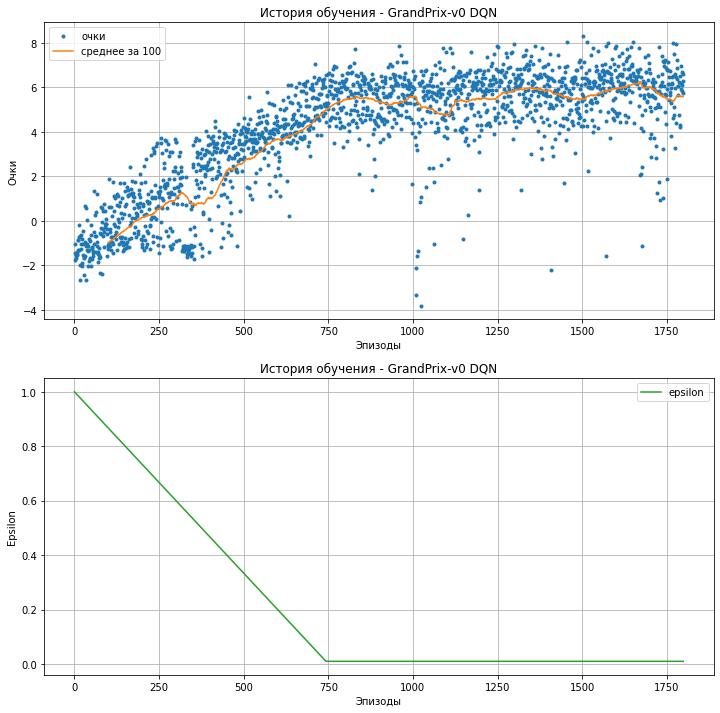

{'algo': 'DQN',
 'avg_reward': 5.0,
 'batch_size': 128,
 'buf_size': 100000,
 'env_name': 'GrandPrix-v0',
 'eps_factor': 4,
 'eps_min': 0.01,
 'fine': 10.0,
 'horizon': 30,
 'id': '12',
 'layers': [256, 256],
 'lr': 0.0001,
 'n_episodes': 3000,
 'n_steps': 200,
 'track': 3}

In [ ]:
path = os.path.join(dir, 'history')
plot_history(path)
hp

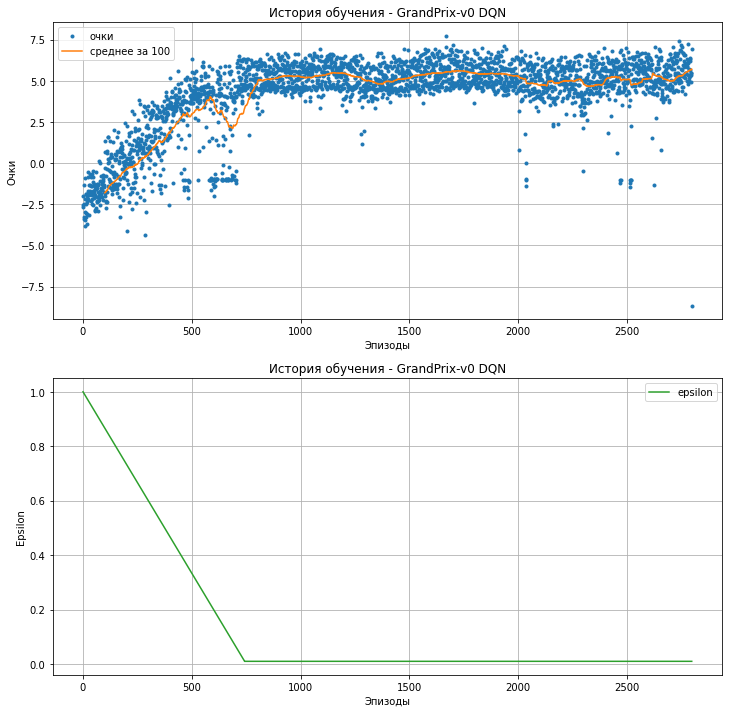

{'algo': 'DQN',
 'avg_reward': 5.0,
 'batch_size': 128,
 'buf_size': 100000,
 'env_name': 'GrandPrix-v0',
 'eps_factor': 4,
 'eps_min': 0.01,
 'fine': 40.0,
 'horizon': 50,
 'id': '05',
 'layers': [256, 256],
 'lr': 0.0001,
 'n_episodes': 3000,
 'n_steps': 200,
 'track': 3}

In [ ]:
plot_history(path)
hp

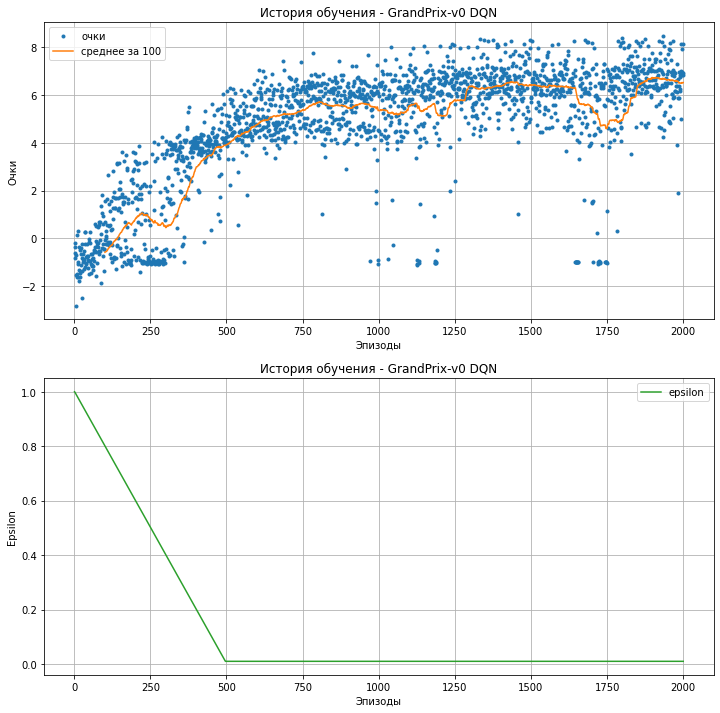

In [ ]:
plot_history(path)

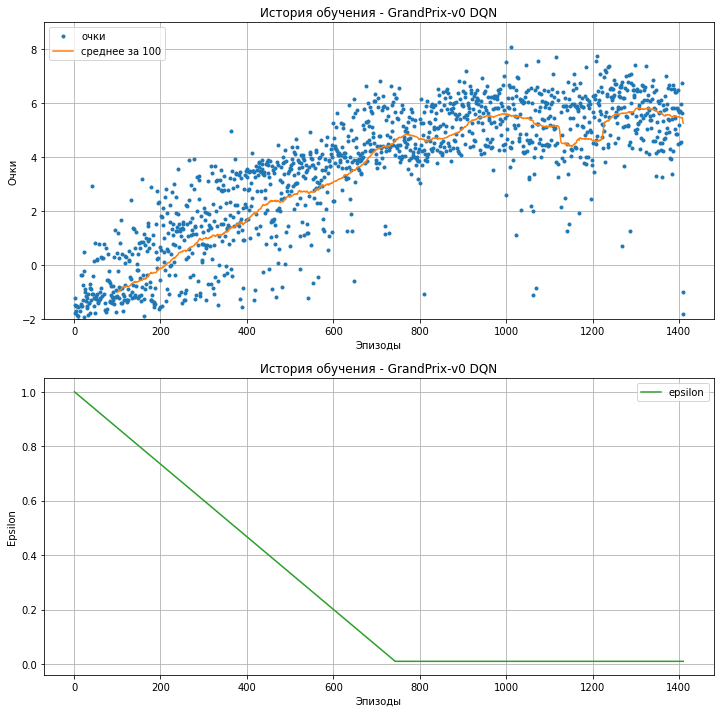

{'algo': 'DQN',
 'avg_reward': 5.0,
 'batch_size': 128,
 'buf_size': 100000,
 'env_name': 'GrandPrix-v0',
 'eps_factor': 4,
 'eps_min': 0.01,
 'fine': 10.0,
 'horizon': 30,
 'id': '02',
 'layers': [256, 256],
 'lr': 0.0001,
 'n_episodes': 3000,
 'n_steps': 200,
 'track': 3}

In [ ]:
plot_history(path, ylim=(-2, 9))
hp

### Тестирование

In [ ]:
checkpoint_file = os.path.join(dir, env_name + '_' + algo)
evalNetwork = DeepQNetwork(lr=lr, n_actions=n_actions, fc1_dims=fc1_dims, fc2_dims=fc2_dims, input_dims=input_dims)
evalNetwork.load_state_dict(T.load(checkpoint_file))
eval = Evaluator(evalNetwork)

In [ ]:
%%time
track = 3
n_rays = 5
n_steps = 2000
env = gym.make(env_name)
env = GrandPrixWrapper(env, fine=0., steps_per_episode=n_steps)
options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
}
episodes = 10
total = 0.
total_coll = 0
obs = env.reset(options=options)
v = []
for ep in range(episodes):
    score = 0.
    collisions = 0
    obs = env.reset()
    done = False
    while not done:
        action = eval.choose_action(obs)
        obs, reward, done, info = env.step(action)
        v.append(obs[0])
        score += reward/n_steps
        if 'collision' in info and info['collision']:
            collisions += 1
    if (ep + 1) % 1 == 0:
        print("episode: %d Score: %.3f Collisions: %d" % (ep+1, score, collisions))
    total += score
    total_coll += collisions
print("Average score %.3f Avg collisions: %.3f" % (total/episodes, total_coll/episodes))
v = np.array(v)
print('Vmax:%.3f Vmean:%.3f Vstd:%.3f' % (v.max(), v.mean(), v.std()))

episode: 1 Score: 5.421 Collisions: 35
episode: 2 Score: 5.508 Collisions: 39
episode: 3 Score: 5.714 Collisions: 29
episode: 4 Score: 5.723 Collisions: 36
episode: 5 Score: 5.575 Collisions: 39
episode: 6 Score: 5.480 Collisions: 39
episode: 7 Score: 5.514 Collisions: 38
episode: 8 Score: 5.895 Collisions: 32
episode: 9 Score: 6.075 Collisions: 19
episode: 10 Score: 5.564 Collisions: 31
Average score 5.647 Avg collisions: 33.700
Vmax:2.862 Vmean:1.461 Vstd:0.577
CPU times: user 1min 56s, sys: 2.1 s, total: 1min 58s
Wall time: 1min 56s


### Video

In [ ]:
track = 3
n_rays = 5
n_steps = 2000
env = gym.make(env_name)
env = GrandPrixWrapper(env, fine=0., steps_per_episode=n_steps )
env = Monitor(env, os.path.join(dir, 'video'), force=True)

options = {
    'nrays': n_rays,
    'seed': track, # задает номер трека
    'display': 1
}

obs = env.reset(options=options)
done = False
score = 0.
while not done:
    env.render()
    action = eval.choose_action(obs)
    obs, reward, done, _ = env.step(action)
    score += reward/n_steps
env.close()
print("Score=%.3f" % score)
show_video(dir)
hp

Score=5.883


{'algo': 'DQN',
 'avg_reward': 5.0,
 'batch_size': 128,
 'buf_size': 100000,
 'env_name': 'GrandPrix-v0',
 'eps_factor': 4,
 'eps_min': 0.01,
 'fine': 40.0,
 'horizon': 50,
 'id': '05',
 'layers': [256, 256],
 'lr': 0.0001,
 'n_episodes': 3000,
 'n_steps': 200,
 'track': 3}

#End
